<a href="https://colab.research.google.com/github/harshading/Hindi-Facial-Emotion-Synthesis/blob/master/ASR_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/automatic-speech-recognition-data-collection-with-youtube-v3-api-mask-rcnn-and-google-vision-api-2370d6776109

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [ ]:
%%capture

# GPU:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
!pip install pydub
# !pip install torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import math
from torch.autograd import Variable

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Load Data

In [ ]:
data_dir = '/content/drive/MyDrive/ASR_Project/'
au_dir = data_dir+'au_dir/'
audio_dir = data_dir+'split_audios_dir/'

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd

def load_audios():
    onlyfiles = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f))]
    audio_dataset = [(f[:-4], *torchaudio.load(audio_dir+f)) for f in onlyfiles]
    return audio_dataset

def load_aus():
    onlyfiles = [f for f in listdir(au_dir) if isfile(join(au_dir,f))]
    columns = pd.read_csv(au_dir+onlyfiles[0], delimiter=',').columns[1:]
    au_dataset = [(f[:-8], pd.read_csv(au_dir+f, delimiter=',').mean().values[1:]) for f in onlyfiles]
    return columns, au_dataset

In [ ]:
audio_dataset = load_audios()

In [ ]:
print(f"Total Audio Files: {len(audio_dataset)}")

Total Audio Files: 1202


In [ ]:
au_header, au_dataset = load_aus()

In [ ]:
print(f"Total Au Files: {len(au_dataset)}")

Total Au Files: 1202


In [ ]:
print(f"All sample rates: {set([data[2] for data in audio_dataset])}")

All sample rates: {44100}


In [ ]:
resample_transform = torchaudio.transforms.Resample(44100, 16000)

Name of file: avr_NZZWN6g-235
Shape of waveform: torch.Size([2, 81920])
Sample rate of waveform: 44100


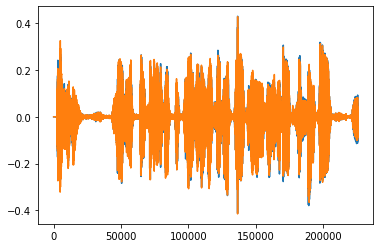

In [ ]:
name, waveform, sample_rate = audio_dataset[0]
print(f"Name of file: {name}")
print(f"Shape of waveform: {resample_transform(waveform).size()}")
print(f"Sample rate of waveform: {sample_rate}")

plt.plot(waveform.t().numpy());

In [ ]:
#========== CHECK Speech
# display(ipd.Audio(waveform,  rate=sample_rate))
# print(f"Sample Rate: {sample_rate}")

In [ ]:
melspec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000)
wave_melspec   = melspec_transform(resample_transform(waveform))
print(wave_melspec.shape)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([2, 128, 410])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [ ]:
name, au_array = au_dataset[0]
print(f"AU Header: {au_header}")
print(f"Name of file: {name}")
print(f"Shape of AU: {au_array.shape}")
print(f"AU: {au_array}")

AU Header: Index(['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r'],
      dtype='object')
Name of file: avr_NZZWN6g-033
Shape of AU: (17,)
AU: [0.1425     0.04932692 0.44548077 0.05403846 0.80692308 0.22346154
 0.04259615 0.32009615 0.43384615 0.48163462 0.08644231 0.43682692
 0.06778846 0.12048077 0.30653846 0.36923077 0.12471154]


In [ ]:
audio_mapset = {}
for name, wave_arr, _ in audio_dataset:
    audio_mapset[name] = wave_arr

au_mapset = {}
for name, au_arr in au_dataset:
    au_mapset[name] = au_arr

total_dataset = [(name, resample_transform(audio_mapset[name]), au_mapset[name]) for name in audio_mapset]

In [ ]:
import random
random.shuffle(total_dataset)

In [ ]:
print(f"Total Length: {len(total_dataset)}")

name, audio_arr, au_arr = total_dataset[0]
print(f"Name: {name}")
print(f"Normal Audio Shape: {audio_arr.shape}")
print(f"Mono Audio Shape: {audio_arr.mean(dim=0).shape}")
print(f"Mono Audo Feature Shape: {melspec_transform(audio_arr.mean(dim=0)).unsqueeze(0).shape}")
print(f"Au Shape: {au_arr.shape}")

Total Length: 1202
Name: kjZdtb52LRs-026
Normal Audio Shape: torch.Size([2, 86100])
Mono Audio Shape: torch.Size([86100])
Mono Audo Feature Shape: torch.Size([1, 128, 431])
Au Shape: (17,)


In [ ]:
all_audio_lengths = sorted(set([element[1].shape[1] for element in total_dataset]), reverse=True)
max_audio_length = max(all_audio_lengths)
print(f"All Audio Lengths: {all_audio_lengths}")
print(f"Max Audio Length: {max_audio_length}")

All Audio Lengths: [88190, 87772, 87354, 86936, 86518, 86100, 85682, 85264, 84846, 84428, 84010, 83174, 82756, 82338, 81920, 81503, 81085, 80667, 80249, 79413, 78995, 77741, 77323, 76905, 76487, 76069, 75651, 74815, 73979, 73561, 72725, 71054, 70636, 70218, 69800, 69382, 68964, 68546, 67292, 66874, 64784, 64366, 63948, 60187, 56425, 56007, 55589, 54335, 52245, 50156, 49738, 49320, 48902, 48484, 47230, 46812, 43886, 43468, 42214, 39289, 38871, 33437, 28840, 28004, 27168, 24660, 24242, 19645, 19227, 14629, 10867, 8352, 7937, 6673, 6256, 5841, 5008, 2080, 1249, 832]
Max Audio Length: 88190


In [ ]:
total_length = len(total_dataset)
train_length = int(total_length * 0.9)

train_dataset = total_dataset[:train_length]
test_dataset = total_dataset[train_length:]
print(f"Train Length: {len(train_dataset)}")
print(f"Test Length: {len(test_dataset)}")

Train Length: 1081
Test Length: 121


#Transformer Based Model

Positional Encoding

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)


        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # add pe constatns to embeddings
        seq_len = x.size(1)

        # print(f"PE Shape:{self.pe.shape}")
        # print(f"X shape: {x.shape}")
        # print(f"Seq Len: {seq_len}")
        # print(f"Added PE Shape: {self.pe[:,:seq_len,:].shape}")

        x = x + self.pe[:,:seq_len, :]  #.cuda().detach()
        return self.dropout(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, N_encoder_layers, heads, d_ff, max_seq_len):
        super().__init__()
        self.N = N_encoder_layers
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, max_seq_len)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, heads, d_ff, dropout=0.3),
            self.N
        )
        # self.layers = get_clones(
        #     EncoderLayer(d_model, heads, d_ff),
        #     # nn.TransformerEncoderLayer(d_model, heads, d_ff),
        #      self.N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, src):
        # print(f"Before PE X shape: {src.shape}")
        x = self.pe(src)

        # x = (batch_size, seq_len, d_model)
        # but Transformer Encoder layer accepts
        # (seq_len, batch_size, d_model)
        x = x.transpose(0,1)
        x = self.encoder(x)
        # for i in range(self.N):
        #     x = self.layers[i](x)
        x = x.transpose(0,1)
        
        return self.norm(x)

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batcorch.Size([1, 43h norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        # print(f"Before Layer Norm shape: {x.shape}")
        x = self.layer_norm1(x)
        x = torch.tanh(x) #F.relu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = torch.tanh(x) #F.relu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

In [ ]:
class SpeechModel(nn.Module):
    def __init__(self, max_seq_len, n_feats, N_cnn_layers, n_channels,\
                 N_encoder_layers, d_model, d_ff, heads,N_AUs,\
                 stride=2, dropout=0.1,\
        ):
        super().__init__()
        self.cnn = nn.Conv2d(1, n_channels, 3, stride=1, padding=3//2)
        # cnn for extracting heirachal features

        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(n_channels, n_channels, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(N_cnn_layers)
        ])
        self.fc = nn.Linear(n_channels*n_feats, d_model) #n_channels

        self.encoder = Encoder(d_model, N_encoder_layers, heads, d_ff, max_seq_len)
        self.linear = nn.Linear(d_model, N_AUs)

    def forward(self, src):  # input: (batch, 1, feature, time)
        x = self.cnn(src)    # (batch, channel, feature, time)
        # print(f"After CNN shape: {x}")

        x = self.rescnn_layers(x)
        # print(f"After RES shape: {x}")

        sizes = x.size()
        x = x.view(sizes[0], sizes[1]*sizes[2], sizes[3])  # (batch, channel*feature, time)
        x = x.transpose(1, 2) # (batch, time, channel*feature)
        x = self.fc(x)        # (batch, time, d_model)
        x = torch.tanh(x)

        # print(f"Befor Encoder X shape: {x}")

        e_outputs = self.encoder(x) # (batch_size, seq_len, d_model)

        # print(f"Encoder Output: {e_outputs}")
        avg_enc   = torch.mean(x, -2)   # (batch_size, d_model)

        # print(f"Average Encoder: {avg_enc}")
        output = self.linear(avg_enc)  #(batch_size, N_AUs)

        # print(f"Output before Sigmoid: {output}")
        output = 5*nn.Sigmoid()(output)
        # print(f"Output : {output}")
        return output

#Data Loaders

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)

      # >>> a = torch.ones(25, 300)
      # >>> b = torch.ones(22, 300)
      # >>> c = torch.ones(15, 300)
      # >>> pad_sequence([a, b, c], True).size() = torch.Size([3, 25, 300])
      # Pad Mask Not Requires since spectogram take care of zeros
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # name, audo_arr, au_arr

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for name, audio_arr, au_arr in batch:
        # print(f"Audio Arr: {audio_arr.shape}")
        # print(f"Au Arr: {au_arr.shape}")
        tensors += [audio_arr.mean(dim=0, keepdims=True)]
        targets += [torch.tensor(au_arr)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    # print(f"Tensors Shape: {tensors.shape}")
    # print(f"Target Shape: {targets.shape}")

    return tensors, targets


batch_size = 32
# Train Length = 1081, Total Batches = 1081/32 = 34

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
max_seq_length = 441 # We already know

is_find_max_seq = False

if is_find_max_seq:
    for data, au in train_loader:
        print(melspec_transform(data.to(device)).shape)
    for data, au in test_loader:
        print(melspec_transform(data.to(device)).shape)

print(f"Max Audio Length: {max_audio_length}")
print(f"Max Seq Length: {max_seq_length}")

Max Audio Length: 88190
Max Seq Length: 441


#Parameters

In [ ]:
heads = 8
N_encoder_layers = 4
d_model = 512 #512
d_ff = 2048 #2048
N_AUs = 17  # TO BE EDIT

max_seq_len = 441 #max_seq_length # TO BE EDIT
n_channels = 16
N_cnn_layers = 1
n_feats = 128 # TO BE EDIT
n_mels = 128

In [ ]:
model = SpeechModel(max_seq_len, n_feats, N_cnn_layers, n_channels, N_encoder_layers,\
                    d_model, d_ff, heads, N_AUs)

In [ ]:
# Very Important to initialize parameters such that it stops
# signal from fading or getting too big
for p in model.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p)


In [ ]:
clip_value = 1.0
for p in model.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [ ]:
print(f"No of parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}")

No of parameters: 13673681


In [ ]:
model

SpeechModel(
  (cnn): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (fc): Linear(in_features=2048, out_features=512, bias=True)
  (encoder): Encoder(
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_fea

#Train

In [ ]:
def train(model, epoch, log_interval):
    model.to(device).double()
    melspec_transform.to(device)

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = melspec_transform(data.to(device)).to(device) # (batch_size, 1, feature, time)
        target = target.to(device).double()
        target[torch.isnan(target)] = 0

        optimizer.zero_grad()
        # print(f"Before CNN: {data}")
        output = model(data.double())  #(batch_size, N_AUs)
    
        output =  output.view(-1, 1)
        target =  target.view(-1, 1)
        loss = F.mse_loss(output, target).double() # Mse Loss On(batch x N_AUs)

        l2_lambda = 0.1  #0.01
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
          l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
        # print(f"Data Type: {data.dtype}")
        # print(f"Output Type: {output.dtype}")
        # print(f"Loss Type: {loss.dtype}")

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def test(model, epoch):
    model.to(device).double()
    melspec_transform.to(device)

    model.eval()
    loss = 0

    with torch.no_grad():
      for data, target in test_loader:

          data = melspec_transform(data.to(device)).to(device) # (batch_size, 1, feature, time)
          target = target.to(device).double()
          target[torch.isnan(target)] = 0

          output = model(data.double())  #(batch_size, N_AUs)

          # pred = get_likely_index(output)
          # correct += number_of_correct(pred, target)
          # print(f"output:{output.shape}")
          # print(f"target: {target.shape}")
          # print(f"Data Type: {data.dtype}")
          # print(f"Output Type: {output.dtype}")

          loss += F.mse_loss(output, target).double()
          # print(loss)

          # update progress bar
          # pbar.update(pbar_update)

    loss = loss/len(test_loader.dataset)
    print(f"\n Test Epoch: {epoch} \t Loss: {loss:.4f} \n")
    return loss

In [ ]:
test(model, 1)


 Test Epoch: 1 	 Loss: 0.1733 



tensor(0.1733, device='cuda:0', dtype=torch.float64)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
for i,(name, child) in enumerate(model.named_children()):
  for param in child.parameters():
    print(f"name: {name} => param: {param}")

In [ ]:
log_interval = 20
#============ UPDATING number of epochs ====================
n_epoch = 35

pbar_update = 1 / (len(train_loader)+len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
melspec_transform = melspec_transform.to(device)
model = model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        losses += [test(model, epoch)]
        if epoch % 7 == 0:
          torch.save(model.state_dict(), data_dir+'/SunilModel')
        scheduler.step()

Train Epoch: 1 [0/1081 (0%)]	Loss: 76.071918
Train Epoch: 1 [640/1081 (59%)]	Loss: 69.737045

 Test Epoch: 1 	 Loss: 0.0243 

Train Epoch: 2 [0/1081 (0%)]	Loss: 67.123883
Train Epoch: 2 [640/1081 (59%)]	Loss: 64.042819

 Test Epoch: 2 	 Loss: 0.0062 

Train Epoch: 3 [0/1081 (0%)]	Loss: 62.264362
Train Epoch: 3 [640/1081 (59%)]	Loss: 59.956676

 Test Epoch: 3 	 Loss: 0.0058 

Train Epoch: 4 [0/1081 (0%)]	Loss: 58.379173
Train Epoch: 4 [640/1081 (59%)]	Loss: 56.169008

 Test Epoch: 4 	 Loss: 0.0056 

Train Epoch: 5 [0/1081 (0%)]	Loss: 54.773908
Train Epoch: 5 [640/1081 (59%)]	Loss: 52.821775

 Test Epoch: 5 	 Loss: 0.0055 

Train Epoch: 6 [0/1081 (0%)]	Loss: 51.513827
Train Epoch: 6 [640/1081 (59%)]	Loss: 49.688415

 Test Epoch: 6 	 Loss: 0.0053 

Train Epoch: 7 [0/1081 (0%)]	Loss: 48.494338
Train Epoch: 7 [640/1081 (59%)]	Loss: 46.842409

 Test Epoch: 7 	 Loss: 0.0054 

Train Epoch: 8 [0/1081 (0%)]	Loss: 45.725490
Train Epoch: 8 [640/1081 (59%)]	Loss: 44.228421

 Test Epoch: 8 	 Loss: 0

KeyboardInterrupt: ignored

# Show Stored Results (Running the model gives following train and test losses)

In [ ]:
import matplotlib.pyplot as plt

epochs       = list(range(1, 11))
test_losses  = [0.0243, 0.0062, 0.0058, 0.0056, 0.0055, 0.0053, 0.0054, 0.0053, 0.0051, 0.0052]
train_losses = [76.071918, 67.123883, 62.264362, 58.379173, 54.773908, 
                51.513827, 48.494338, 45.725490, 43.191196, 40.835008]

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, train_losses, marker='o', color='r')
plt.xlabel("Epochs")
plt.ylabel("Train Mse Loss with L2 Regularization")
plt.title("Train loss va epochs")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, test_losses, marker='o', color='r')
plt.xlabel("Epochs")
plt.ylabel("Test Mse Loss")
plt.title("Test loss va epochs")
plt.show()